In [24]:
import torch
print(torch.__version__)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from PIL import JpegImagePlugin

1.1.0


### Gpu infor

In [2]:
### Check Gpu 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [3]:
### Get Gpu infor
if device.type == 'cuda':
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

1
Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Transfer Learning

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [5]:
### Turn the interactive mode on
plt.ion()

### Load Data

In [6]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229, 0.224, 0.225])
    ]),
    "val":transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229, 0.224, 0.225])
    ])
}

In [7]:
data_dir = 'hymenoptera_data'
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x]) for x in ["train", "val"]}
dataloders = {x:torch.utils.data.DataLoader(image_datasets[x], batch_size = 4, shuffle = True, num_workers = 4)
             for x in ["train", "val"]}
dataset_sizes = {x:len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

### Visualize images

In [8]:
def imshow(inp, title = None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = inp * std + mean
    ### using clip (0, 1) here, since the RGB values should between 0 and 1
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    

In [9]:
inputs, classes = next(iter(dataloders["train"]))
### torchvision.utils.make_grid can make graph showing in grid format
out = torchvision.utils.make_grid(inputs)

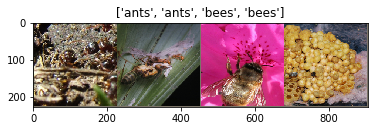

In [10]:
imshow(out,title = [class_names[x] for x in classes])

In [11]:
classes.data

tensor([0, 0, 1, 1])

### Training Model

In [12]:
def train_model(model, criterion, optimizer, schedular, num_epochs = 25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch,num_epochs-1))
        print("-" * 10)
        
        for phase in ["train", "val"]:
            if phase == "train":
                ### .step() is used to update the learning rate/gradients ###
                schedular.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in dataloders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    ### return the max value in outputs with both value and indice ###
                    ### Here, 1 is the dimension to reduce ###
                    _,preds = torch.max(outputs,1)
                    ### loss are averaged across observations for each minibatch ###
                    loss = criterion(outputs,labels)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            ### tensor.double() is to convert the tensor type into torch.float64 ###
            epoch_acc = running_corrects.double()/dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc:{:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc  = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    
    return model                  

### Visualize the predictions

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _,preds = torch.max(outputs, 1)
            for j in range(inputs.size(0)):
                image_so_far +=1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode = was_training)

### Finetuning the convnet

In [14]:
model_ft = models.resnet18(pretrained = True)


In [15]:
### This is for final linear layer, and needed be retrained in transfer learning ###
### Previously, in Convnet inputs is 512, outputs is 1000, which is for 1000 classes###
### Here, we changed it into 2, which means we only have two classes ###
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,2)

In [16]:
model_ft = model_ft.to("cuda")

In [17]:
criterion = nn.CrossEntropyLoss()

In [18]:
### Implements stochastic gradient descent 
optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.001, momentum = 0.9)

In [19]:
### Decay LR by a factor of 0.1 every 7 epochs
exp_lr_schedular = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [25]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_schedular, num_epochs=25)

Epoch 0/24
----------


Exception ignored in: <function _DataLoaderIter.__del__ at 0x2ad0c33382f0>
Exception ignored in: <function _DataLoaderIter.__del__ at 0x2ad0c33382f0>
Exception ignored in: <function _DataLoaderIter.__del__ at 0x2ad0c33382f0>
Exception ignored in: <function _DataLoaderIter.__del__ at 0x2ad0c33382f0>
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/beegfs/jl7003/anaconda3_latest/envs/pytorch_env/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
  File "/beegfs/jl7003/anaconda3_latest/envs/pytorch_env/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
  File "/beegfs/jl7003/anaconda3_latest/envs/pytorch_env/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
  File "/beegfs/jl7003/anaconda3_latest/envs/pytorch_env/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    

train Loss: 0.6227 Acc:0.7377


Exception ignored in: <function _DataLoaderIter.__del__ at 0x2ad0c33382f0>
Exception ignored in: <function _DataLoaderIter.__del__ at 0x2ad0c33382f0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/beegfs/jl7003/anaconda3_latest/envs/pytorch_env/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
  File "/beegfs/jl7003/anaconda3_latest/envs/pytorch_env/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
Exception ignored in: <function _DataLoaderIter.__del__ at 0x2ad0c33382f0>
    self._shutdown_workers()
    self._shutdown_workers()
Traceback (most recent call last):
  File "/beegfs/jl7003/anaconda3_latest/envs/pytorch_env/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
  File "/beegfs/jl7003/anaconda3_latest/envs/pytorch_env/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
  File "/beegfs/jl7003/anaconda3_latest/envs/p

UnboundLocalError: Traceback (most recent call last):
  File "/beegfs/jl7003/anaconda3_latest/envs/pytorch_env/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 99, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/beegfs/jl7003/anaconda3_latest/envs/pytorch_env/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 99, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/beegfs/jl7003/anaconda3_latest/envs/pytorch_env/lib/python3.7/site-packages/torchvision/datasets/folder.py", line 132, in __getitem__
    sample = self.loader(path)
  File "/beegfs/jl7003/anaconda3_latest/envs/pytorch_env/lib/python3.7/site-packages/torchvision/datasets/folder.py", line 178, in default_loader
    return pil_loader(path)
  File "/beegfs/jl7003/anaconda3_latest/envs/pytorch_env/lib/python3.7/site-packages/torchvision/datasets/folder.py", line 160, in pil_loader
    img = Image.open(f)
  File "/beegfs/jl7003/anaconda3_latest/envs/pytorch_env/lib/python3.7/site-packages/PIL/Image.py", line 2690, in open
    im = _open_core(fp, filename, prefix)
  File "/beegfs/jl7003/anaconda3_latest/envs/pytorch_env/lib/python3.7/site-packages/PIL/Image.py", line 2676, in _open_core
    im = factory(fp, filename)
  File "/beegfs/jl7003/anaconda3_latest/envs/pytorch_env/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 783, in jpeg_factory
    im = JpegImageFile(fp, filename)
  File "/beegfs/jl7003/anaconda3_latest/envs/pytorch_env/lib/python3.7/site-packages/PIL/ImageFile.py", line 103, in __init__
    self._open()
  File "/beegfs/jl7003/anaconda3_latest/envs/pytorch_env/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 373, in _open
    handler(self, i)
  File "/beegfs/jl7003/anaconda3_latest/envs/pytorch_env/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 139, in APP
    self.info["photoshop"] = photoshop
UnboundLocalError: local variable 'photoshop' referenced before assignment


In [28]:
x.shape[1]

3

In [70]:
x.size(0)

3

In [19]:
loss

tensor(1.5332, grad_fn=<NllLossBackward>)

In [95]:
torch.max?

In [54]:
a = torch.randn(1,3)

In [42]:
a

tensor([[-1.3551,  0.6478,  0.9244]])

In [64]:
a.double()

tensor([[-0.1590, -0.0770,  0.3368]], dtype=torch.float64)

In [66]:
_, preds = torch.max(a,1)

In [67]:
preds

tensor([2])

In [ ]:
schedular?
optimizer?

In [112]:
torch.optim.lr_scheduler?